In [85]:
import numpy as np
from numpy.linalg import multi_dot

import numpy.linalg as lin

import csv

import pandas as pd

from pathlib import Path

In [86]:
# Reading dataset.

__file__ = 'recommender.ipynb'
base_path = Path(__file__).parent

file_path = (base_path / '../ml-latest-small/ratings.csv').resolve()
with open(file_path) as f:
    ratings = [line for line in csv.reader(f)]
    
file_path = (base_path / '../ml-latest-small/movies.csv').resolve()
with open(file_path) as f:
    movies = [line for line in csv.reader(f)]

In [87]:
# Building rating and movies dataframes from dataset.

# Building dataframes, fixing types and dropping useless columns.
ratings_df = pd.DataFrame(ratings,columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']).iloc[1:]
ratings_df[['UserID', 'MovieID']] = ratings_df[['UserID', 'MovieID']].astype(int) - 1 # 0 index.
ratings_df[['Rating']] = ratings_df[['Rating']].astype(float)
ratings_df.drop(['Timestamp'], inplace = True, axis = 1)

movies_df = pd.DataFrame(movies, columns = ['MovieID', 'Title', 'Genres']).iloc[1:1300]
movies_df[['MovieID']] = movies_df[['MovieID']].astype(int) - 1 # 0 index.


# Movie index correction.
movie_index = pd.DataFrame([i for i in range(0, movies_df['MovieID'].shape[0])], columns = ['NewID'])
movie_index['MovieID'] = movies_df['MovieID'].to_numpy()

# Fix movies_df MovieIDs
movies_df = pd.merge(movie_index, movies_df, on = 'MovieID', how = 'inner').drop(['MovieID'], axis = 1)
movies_df.columns = ['MovieID', 'Title', 'Genres']

# Fix ratings_df MovieIDs
ratings_df = pd.merge(movie_index, ratings_df, on = 'MovieID', how = 'inner').drop(['MovieID'], axis = 1)
ratings_df.columns = ['MovieID', 'UserID', 'Rating']

In [88]:
# Creating R dataframe.

R_df = pd.merge(ratings_df, movies_df, on = "MovieID", how = "inner")

R_df = pd.pivot_table(R_df, index = ['MovieID', 'UserID', 'Genres', 'Title'])
R_df = pd.DataFrame(R_df.to_records())

R_df.head()

,MovieID,UserID,Genres,Title,Rating
0,0,0,Adventure|Animation|Children|Comedy|Fantasy,Toy Story (1995),4.0
1,0,4,Adventure|Animation|Children|Comedy|Fantasy,Toy Story (1995),4.0
2,0,6,Adventure|Animation|Children|Comedy|Fantasy,Toy Story (1995),4.5
3,0,14,Adventure|Animation|Children|Comedy|Fantasy,Toy Story (1995),2.5
4,0,16,Adventure|Animation|Children|Comedy|Fantasy,Toy Story (1995),4.5


In [89]:
# Build R matrix and dividing training/test sets.

from scipy.sparse import coo_matrix, csr_matrix

np.random.seed(17)

R_users = R_df["UserID"].to_numpy().flatten()
R_movies = R_df["MovieID"].to_numpy().flatten()
R_ratings = R_df["Rating"].to_numpy().flatten()

# csr_matrix((dat, (row, col)))
R = csr_matrix((R_ratings, (R_users, R_movies)))
R = R.toarray()

print("Shape of R matrix: {}".format(np.shape(R)))

# Dividing training and test set.

# Test set percentage.
p_test = 0.2

# Random boolean, TRUE for test set.
mask = np.random.choice(a = [False, True], size = R.size, p = [p_test, 1 - p_test]).reshape(R.shape)

R_test = np.zeros(R.shape)
R_test[mask] = R[mask]

R_train = np.zeros(R.shape)
R_train[np.invert(mask)] = R[np.invert(mask)]

np.array_equal(R, R_test + R_train)
R_train

Shape of R matrix: (610, 1299)


array([[0., 0., 4., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [90]:
# Obtaining weights matrix C.

### Do the weights make sense? ###

#M = 10
M = np.shape(R_train)[0]
#N = 20
N = np.shape(R_train)[1]

# Unobserbed weights.
w0 = 1

c = [ np.count_nonzero(R_train[:, i]) for i in range(0, np.shape(R_train)[1]) ]
#C = R * c + w0
alpha = 10
C = 1 + alpha * R_train

C

array([[ 1.,  1., 41., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       ...,
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.]])

In [91]:
# Building random X and Y matrices of proper dimension.

#K = 5
K = 100

X = np.random.rand(M, K)
Y = np.random.rand(N, K)

In [92]:
# Define functions to compute approximated ratings and error.

def predict(X, Y):
    return np.dot(X, Y.T)

def error(predicted_ratings, ratings, w0):
    obs_idx = np.where(ratings > 0)
    nobs_idx = np.where(ratings == 0)
    obs_error = sum( (ratings[obs_idx] - predicted_ratings[obs_idx]) ** 2 )
    nobs_error = sum( (ratings[nobs_idx] - predicted_ratings[nobs_idx]) ** 2 )
    return obs_error + w0 * nobs_error

In [93]:
# Testing functions. Error should be computer between the predicted ratings and the R_test set.

predicted_ratings = predict(X, Y)
w0 = 1
error(predicted_ratings, R_test, w0)

494173564.8164117

In [94]:
import scipy.optimize.nnls as nnls

### Should solutions be non-negative? (or further constrained to be [0.5, 5]) ##

def singlePassWALS(R, X, Y, C, reg_lambda):
    M = np.shape(X)[0]
    K = np.shape(X)[1]
    N = np.shape(Y)[0]
    
    #XX = np.dot(X.T, X)
    #YY = np.dot(Y.T, Y)

    for u in range(1, M):
        Cu = np.diag(C[u, :])
        # A X_u = b
        A = multi_dot([Y.T, Cu, Y]) + reg_lambda * np.eye(K)
        #A = YY + multi_dot([Y.T, Cu - np.eye(N), Y])
        b = multi_dot([Y.T, Cu, R[u, :]])
        X_u = np.linalg.solve(A, b)
        #X_u = nnls(A, b)[0]
        
        X[u,] = X_u
        
    for i in range(1, N):
        Ci = np.diag(C[:,i])
        # A Y_i = b
        A = multi_dot([X.T, Ci, X]) + reg_lambda * np.eye(K)
        #A = XX + multi_dot([X.T, Ci - np.eye(M), X])
        b = multi_dot([X.T, Ci, R[:, i]])
        Y_i = np.linalg.solve(A, b)
        #Y_i = nnls(A, b)[0]
        
        Y[i,] = Y_i    
    

In [95]:
def WALS(R_train, R_test, X, Y, C, reg_lambda, n_iter):
    for j in range(1, n_iter):
        singlePassWALS(R_train, X, Y, C, reg_lambda)
        predicted_ratings = predict(X, Y)
        w0 = 0.5
        print("Error: " + str(error(predicted_ratings, R_test, w0)))

In [107]:
# Compute WALS.

reg_lambda = 0.1
n_iter = 5


#WALS(R_train, R_test, X, Y, C, reg_lambda, n_iter)
WALS(R, R, X, Y, C, reg_lambda, n_iter)


predicted_ratings = predict(X, Y)

Error: 90419.0570149718
Error: 89238.01483995268
Error: 88496.96399377118
Error: 87998.1677448896


In [97]:
# Recommend first n results for given user.

def recommendNew(user, R, approx_R):
    pred = np.matrix.round(approx_R, 2)[user]
    
    # Unseen movies.
    idx = np.where(R[user] == 0)[0]
    movie_pred = list(zip(idx, pred[idx]))
    
    # Build prediction dataframe.
    recom_df = pd.DataFrame(movie_pred, columns = ['MovieID', 'Prediction'])
    recom_df = pd.merge(recom_df, movies_df, on = "MovieID", how = "inner")
    recom_df = recom_df.sort_values(by = 'Prediction', ascending = False)
    
    # Add comparison with average ratings.
    avg_rat = ratings_df.groupby('MovieID').mean()
    recom_df = pd.merge(recom_df, avg_rat, on = "MovieID", how = "inner")
    recom_df.drop(['UserID'], inplace = True, axis = 1)
    recom_df.round({'Rating': 1})
    recom_df.rename(columns={'Rating':'AVG_Rating'}, inplace=True)
    
    return recom_df


In [108]:
recommendNew(6, R, predicted_ratings).head(10)

,MovieID,Prediction,Title,Genres,AVG_Rating
0,398,1.97,"Fugitive, The (1993)",Thriller,3.992105
1,257,1.93,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,4.197068
2,957,1.81,"Shining, The (1980)",Horror,4.082569
3,474,1.59,Blade Runner (1982),Action|Sci-Fi|Thriller,4.100806
4,1183,1.58,Men in Black (a.k.a. MIB) (1997),Action|Comedy|Sci-Fi,3.487879
5,902,1.58,Aliens (1986),Action|Adventure|Horror|Sci-Fi,3.964286
6,302,1.43,Ace Ventura: Pet Detective (1994),Comedy,3.040373
7,1236,1.40,The Devil's Advocate (1997),Drama|Mystery|Thriller,3.411765
8,201,1.39,Ed Wood (1994),Comedy|Drama,3.678571
9,1291,1.26,Titanic (1997),Drama|Romance,3.414286


In [109]:
comparison = R_df.query('UserID == 6').sort_values(by = "Rating", ascending = False)
print(len(comparison))
comparison.head(10)

36


,MovieID,UserID,Genres,Title,Rating
16231,510,6,Crime|Horror|Thriller,"Silence of the Lambs, The (1991)",5.0
33094,1187,6,Drama|Sci-Fi,Contact (1997),5.0
28569,969,6,Adventure|Comedy|Sci-Fi,Back to the Future (1985),5.0
27290,939,6,Action|Sci-Fi|Thriller,"Terminator, The (1984)",5.0
6855,224,6,Action|Adventure|Sci-Fi,Star Wars: Episode IV - A New Hope (1977),5.0
10021,314,6,Comedy|Drama|Romance|War,Forrest Gump (1994),5.0
12826,404,6,Action|Comedy|War,Hot Shots! Part Deux (1993),5.0
13087,418,6,Action|Adventure|Sci-Fi|Thriller,Jurassic Park (1993),5.0
26460,920,6,Crime|Horror,Psycho (1960),5.0
2,0,6,Adventure|Animation|Children|Comedy|Fantasy,Toy Story (1995),4.5


In [100]:
# Compares recommendation on test set with actual ratings.

def recommendTest(user_id, R_test, predicted_ratings):
    pred = np.around(predicted_ratings, 2)[user_id]
    # Unseen movies (test set ones)
    idx = np.where(R_test[user_id] != 0)[0]
    # idx = np.where(R[user] == 0)[0]
    movie_pred = list(zip(idx, pred[idx]))
    recom_df = pd.DataFrame(movie_pred, columns = ['MovieID', 'Prediction'])

    recom_df = pd.merge(recom_df, R_df, on = "MovieID", how = "inner")
    recom_df = recom_df[(recom_df.UserID == user_id)]
    recom_df = recom_df.sort_values(by = 'Prediction', ascending = False)
    
    return recom_df

In [110]:
user_id = 6
recommendTest(user_id, R_test, predicted_ratings)

,MovieID,Prediction,UserID,Genres,Title,Rating
2908,911,4.95,6,Action|Adventure|Sci-Fi,Star Wars: Episode VI - Return of the Jedi (1983),4.0
565,224,4.47,6,Action|Adventure|Sci-Fi,Star Wars: Episode IV - A New Hope (1977),5.0
2591,898,4.35,6,Action|Adventure|Sci-Fi,Star Wars: Episode V - The Empire Strikes Back...,4.0
2261,615,4.25,6,Action|Adventure|Sci-Fi|Thriller,Independence Day (a.k.a. ID4) (1996),4.5
1821,510,4.20,6,Crime|Horror|Thriller,"Silence of the Lambs, The (1991)",5.0
3404,969,4.12,6,Adventure|Comedy|Sci-Fi,Back to the Future (1985),5.0
2,0,3.95,6,Adventure|Animation|Children|Comedy|Fantasy,Toy Story (1995),4.5
1407,507,3.24,6,Action|Sci-Fi,Terminator 2: Judgment Day (1991),2.5
2099,546,3.24,6,Action|Adventure|Mystery|Thriller,Mission: Impossible (1996),4.0
1054,418,2.89,6,Action|Adventure|Sci-Fi|Thriller,Jurassic Park (1993),5.0


In [102]:
# TODO:
# new user
# similar items

In [111]:
# Suggesting similar items.
def cosine_similarity(d_1, d_2):
    len_1 = lin.norm(d_1)
    len_2 = lin.norm(d_2)
    return np.dot(d_1, d_2) / (len_1 * len_2)

def similar_items(movie_id, Y):
    # Y is the item embedding
    d_1 = Y[movie_id]
    similarity = [cosine_similarity(Y[movie_id], Y[i]) for i in range(0, np.shape(Y)[0])]
    return similarity

In [112]:
d_1 = np.array([1, 2, 3])
d_2 = np.array([-11, 3, 3])

print(cosine_similarity(Y[3], Y[10]))

-0.040938999603116526


In [124]:
similar_items(1, Y)

recommender.ipynb:5: RuntimeWarning: invalid value encountered in double_scalars
  "execution_count": 19,


[0.005837708860136076,
 1.0,
 0.013228258243963183,
 -0.1067139936149963,
 0.06222954190131015,
 0.04463680045215838,
 -0.068028930477217,
 0.06674818558954156,
 0.011712969426198431,
 0.07308071663306075,
 0.08491795187128946,
 0.09954764695942164,
 0.01183580163641716,
 0.12890209031536165,
 0.1501647568178081,
 -0.008242397994050332,
 -0.06850938068846207,
 0.09058923989597796,
 0.22789170634732248,
 0.10414269407048724,
 -0.17691606706117333,
 -0.004438538876718208,
 0.027344758046942825,
 -0.06779494593274607,
 -0.09628289482698928,
 -0.07444440613993103,
 0.010751733053207776,
 -0.05410233452540524,
 -0.013693098760629557,
 -0.1683626262440483,
 0.1054086407459761,
 0.05940067287923218,
 0.005778197960894305,
 0.009322089916364034,
 0.06362677564646976,
 -0.0877231102226423,
 -0.12177155000606514,
 0.13313945291767976,
 -0.052133255716380986,
 0.08549436252472557,
 0.1339834249031251,
 -0.12609258369479825,
 0.027266891384350022,
 -0.013256596732342288,
 0.0731170739500093,
 0.25

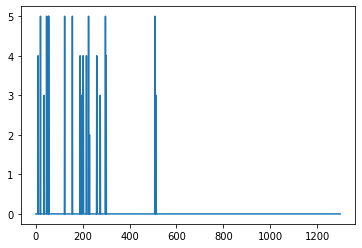

In [63]:
plt.plot(R[34])

In [50]:
import matplotlib.pyplot as plt